# Supernovas con cadenas de Markov

In [189]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics as stats

In [8]:
data = pd.read_csv("/Users/guill/Desktop/AC/da2020-seguragg2018/datos/jla_lcparams.txt", sep=" ").sort_values(by = "zcmb")
data

,#name,zcmb,zhel,dz,mb,dmb,x1,dx1,color,dcolor,...,d3rdvar,tmax,dtmax,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
648,sn1999ac,0.010060,0.009500,0,14.148421,0.174566,0.202688,0.068440,0.048593,0.025981,...,0.128500,51250.610935,0.078970,0.000244,0.000652,-0.000154,3,241.812542,7.972333,-0.008427
691,sn2004s,0.010291,0.009370,0,14.157498,0.173593,-0.117402,0.082511,0.022258,0.024846,...,0.280891,53040.308109,0.290845,-0.000483,0.000665,-0.000348,3,101.431250,-31.231250,-0.008430
641,sn1997do,0.010550,0.010120,0,14.449314,0.173090,0.791332,0.187870,0.118415,0.030547,...,0.280891,50766.597803,0.115604,0.003521,0.000989,0.001322,3,111.677083,47.093333,-0.008434
673,sn2002dp,0.010888,0.011638,0,14.557203,0.169021,-0.316464,0.184325,0.054095,0.023005,...,0.363500,52451.216137,0.133147,0.001596,0.000487,0.001020,3,352.125430,22.427240,-0.008440
713,sn2006bh,0.011184,0.010900,0,14.342973,0.166533,-1.648794,0.032216,-0.083155,0.019407,...,0.352000,53833.523740,0.039787,-0.000039,0.000286,-0.000115,3,340.067078,-66.485085,-0.008446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,06D3en,1.060801,1.060000,0,24.707870,0.132013,-0.952679,0.412773,-0.158207,0.061030,...,0.935000,53881.407872,0.949506,0.010444,-0.003050,0.004456,1,215.305567,52.456079,-0.036389
242,Gabi,1.120850,1.120000,0,25.147113,0.121686,0.620453,0.307485,-0.075491,0.053200,...,0.296000,53488.738514,0.524573,0.004032,0.000388,0.005988,4,189.057630,62.202100,0.000000
243,Lancaster,1.230892,1.230000,0,26.046776,0.128558,-0.077374,0.690464,0.087011,0.048271,...,0.194500,53431.841687,1.597837,0.003542,0.000211,0.008241,4,189.236330,62.214814,0.000000
614,Torngasek,1.265901,1.265000,0,25.735598,0.128614,0.286816,0.559546,0.021062,0.047718,...,0.391000,52693.622067,1.790259,-0.003817,-0.000169,0.003064,4,189.331960,62.310417,0.000000


In [28]:
def lnlikelihood(y, sigma, modelo, parametro):
    return (-1/2)*np.sum(((y-modelo(parametro))**2)/sigma**2)

In [113]:
l_sup = [1, 6, -10, 1.5]
l_inf = [-1, 0, -30, -0.5]

def lnprior(param):
    if l_inf<param<l_sup:
        param = 0
    else:
        param = -1*np.inf
    return param

In [114]:
def montecarlo_chain(y, sigma, modelo, p_i, n, nc):

    markov_matrix = []
    acept = np.zeros(nc)
    
    for ic in range(nc):
    
        P_v = lnlikelihood(y, sigma, modelo, p_i[ic])+lnprior(p_i[ic])
        markov_chain = []
        markov_chain.append([p_i[ic], P_v])

        s = [0.1, 0.1, 0.1, 0.1]

        for i in range(n):
            p_n = []
            p_n = [np.random.normal(p_i[ic][0], s[0]), np.random.normal(p_i[ic][1], s[1]), np.random.normal(p_i[ic][2], s[2]), np.random.normal(p_i[ic][3], s[3])]

            P_n = lnlikelihood(y, sigma, modelo, p_n)+lnprior(p_n)

            if (P_n>P_v):
                markov_chain.append([p_n, P_n])
                acept[ic] = acept[ic]+1
                p_i[ic] = p_n 
                P_v = P_n
                continue
            elif  ((np.exp(P_n)/np.exp(P_v)) > np.random.randn()):
                markov_chain.append([p_n, P_n])
                acept[ic]= acept[ic]+1
    
        markov_matrix.append(markov_chain)
        
    return [markov_matrix, acept]

In [115]:
#Primero definimos nuestro 'x'
mb = []
x1 = []
color = []
for i in range(740): 
  mb.append(data.iloc[i,4])
  x1.append(data.iloc[i,6])
  color.append(data.iloc[i,8])
mb = np.array(mb)
x1 = np.array(x1)
color = np.array(color)

In [116]:
def modelo(parametros):
    return mb-(parametros[2] - parametros[0]*x1 + parametros[1]*color)

p_reales = [0.1, 3, -19, 0.5]

des = np.zeros(len(mb))
for i in range(len(mb)):
    des[i] = 0.1
    
y = mb - (p_reales[2] - p_reales[0]*x1 + p_reales[1]*color)

In [117]:
p_i = [[0.6,7,-10, 0.2],[-0.9,1,-25, 0.1],[0.3,12,-1, 1],[-0.4 ,1.5,-20, 0.4],[0.7, 0.8,-6, 0.1]]
nc = 5
n = 10000

In [118]:
a = montecarlo_chain(y,des,modelo, p_i, n, nc)

<ipython-input-114-8f05e365cf53>:26: RuntimeWarning: invalid value encountered in double_scalars
  elif  ((np.exp(P_n)/np.exp(P_v)) > np.random.randn()):


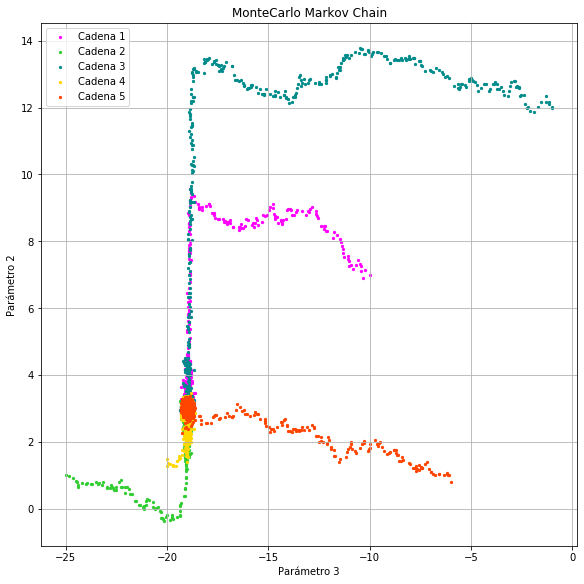

In [160]:
colores = ["#32CD32", "#008B8B", "#FFD700", "#FF4500", "#FF00FF"]
lik = []
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
for i in range(nc):
    puntos = [x for x,y in a[0][i]]
    lik.append([y for x, y in a[0][i]])
    
    p1 = np.zeros(len(puntos)) 
    p2 = np.zeros(len(puntos))
    p3 = np.zeros(len(puntos))
    p4 = np.zeros(len(puntos))
    
    for j in range(len(puntos)):
        p1[j] = puntos[j][0]
        p2[j] = puntos[j][1]
        p3[j] = puntos[j][2]
        p4[j] = puntos[j][3]
        
    plt.scatter(p3, p2, color=colores[i-1],s=5, label='Cadena '+str(i+1))

plt.title('MonteCarlo Markov Chain')
plt.xlabel('Parámetro 3')
plt.ylabel('Parámetro 2')
plt.legend()
plt.grid()

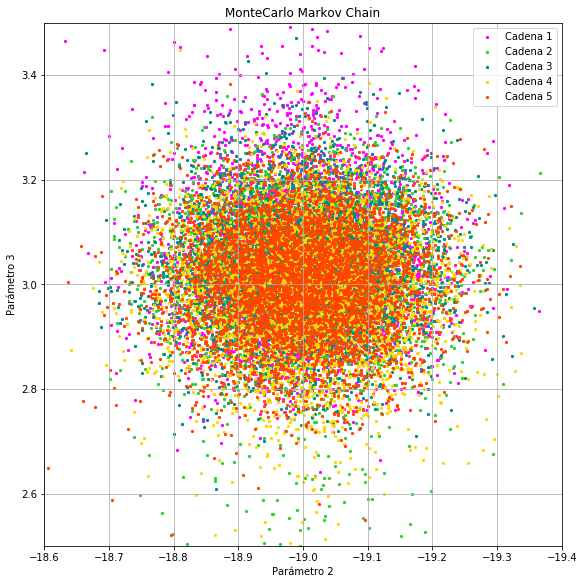

In [146]:
colores = ["#32CD32", "#008B8B", "#FFD700", "#FF4500", "#FF00FF"]
lik = []
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
for i in range(nc):
    puntos = [x for x,y in a[0][i]]
    lik.append([y for x, y in a[0][i]])
    
    p1 = np.zeros(len(puntos)) 
    p2 = np.zeros(len(puntos))
    p3 = np.zeros(len(puntos))
    p4 = np.zeros(len(puntos))
    
    for j in range(len(puntos)):
        p1[j] = puntos[j][0]
        p2[j] = puntos[j][1]
        p3[j] = puntos[j][2]
        p4[j] = puntos[j][3]
        
    plt.scatter(p3, p2, color=colores[i-1],s=5, label='Cadena '+str(i+1))

plt.title('MonteCarlo Markov Chain')
plt.xlabel('Parámetro 2')
plt.ylabel('Parámetro 3')
plt.xlim((-18.6, -19.4))
plt.ylim((2.5, 3.5))
plt.legend()
plt.grid()

In [121]:
print('La fracción de aceptación de cada cadena es la siguiente: ')
for i in range(nc):
    print('Para la cadena ' + str(i+1) + ' es: ' + str(a[1][i]/n))

La fracción de aceptación de cada cadena es la siguiente: 
Para la cadena 1 es: 0.4877
Para la cadena 2 es: 0.4997
Para la cadena 3 es: 0.4743
Para la cadena 4 es: 0.4967
Para la cadena 5 es: 0.5029


## Diagnóstico de Gelman-Rubin

In [205]:
lim_s = [0.45, 3.5, -18.6, 1.3]
lim_i = [-0.25, 2.5, -19.4, -0.3]
R = np.zeros(4)
for nup in range(4):
    pbarr = np.zeros(nc)
    sp_2 = np.zeros(nc)
    mu_p = 0
    count = 0

    for i in range(nc):
        puntos = [x for x,y in a[0][i]]

        p_fin = np.zeros(len(puntos))
    
        for k in range(len(puntos)):
            p_fin[k] = puntos[k][nup]

        p_f = []
        for j in range(len(p_fin)):
            if lim_i[nup]<p_fin[j] and p_fin[j]<lim_s[nup]:
                p_f.append(p_fin[j])
                count = count + 1

        pbarr[i] = stats.mean(p_f)
        sp_2[i] = (1/(n-1))*np.sum((p_f-pbarr[i])**2)
        mu_p = mu_p + np.sum(p_f)

    mu_p = mu_p/count
    s2_p = (1/nc)*np.sum(sp_2)
    bn_p = (1/(nc-1))*np.sum((pbarr-mu_p)**2)
    sig2_p = ((n-1)/n)*s2_p + bn_p

    R[nup] = np.sqrt(sig2_p/s2_p)

In [210]:
print('Los valores encontrados de los radios de convergencia son: ')
print('Para alpha ' + str(R[0]))
print('Para beta  ' + str(R[1]))
print('Para M_b  ' + str(R[2]))
print('Para Omega  ' + str(R[3]))

Los valores encontrados de los radios de convergencia son: 
Para alpha 1.0002378472343392
Para beta  1.034871528026478
Para M_b  1.0013283169139493
Para Omega  6.516897263438396
